In [10]:
import uproot
import awkward as ak
from uproot_methods import TLorentzVectorArray
import numpy as np
from coffea import processor, util

%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

from coffea.nanoaod import NanoEvents
import time

In [2]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np


class HHProcessor(processor.ProcessorABC):
    def __init__(self):

        self._accumulator = processor.dict_accumulator({
            'templates': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('pt', r'Jet $p_{T}$ [GeV]', 50, 300, 1200),
                hist.Bin('mass', r'Jet $m_{SD}$ [GeV]', 10, 100, 150),
                hist.Bin('bbtag1', r'Jet bb 1 tagger score', 20, 0, 1),
                hist.Bin('bbtag2', r'Jet bb 2 tagger score', 20, 0, 1),
                hist.Bin('wwtag', r'Jet WW tagger score', 20, 0, 1),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        
        output = self.accumulator.identity()
        
        selection = processor.PackedSelection()
        weights = processor.Weights(len(events))
        weights.add('genweight', events['weight'])

        dataset = events['dataset']
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            events['nFatJet'],
            pt=events['FatJet_pt'],
            eta=events['FatJet_eta'],
            phi=events['FatJet_phi'],
            mass=events['FatJet_msoftdrop'],
            bbtag=events['FatJet_btagDDBvL'],
            wwtag=events['FatJet_deepTagMDHqqqq']
            )

        candidatejets = fatjets[
            (fatjets.pt > 300)
            & (abs(fatjets.eta) < 2.5)
        ][:, 0:2]
        
        selection.add('jetkin', ((candidatejets.pt >= 300)
                                 & (candidatejets.mass >= 100.)
                                 & (candidatejets.mass <= 150.)
                                 & (abs(candidatejets.eta) < 2.5)
                                ).any())
        
        selection.add('twojets', (candidatejets.counts>=2))
        
        twojets = candidatejets.distincts(nested=True)
        bbbb = ((twojets.i0.bbtag >= 0.9) & (twojets.i1.bbtag >= 0.9)).any()
        bbww = ( ((twojets.i0.bbtag >= 0.9) & (twojets.i0.bbtag > twojets.i1.bbtag) & (twojets.i1.wwtag >= 0.7)) | 
                 ((twojets.i1.bbtag >= 0.9) & (twojets.i1.bbtag > twojets.i0.bbtag) & (twojets.i0.wwtag >= 0.7))).any()


        bbjet1 = JaggedArray.fromoffsets(twojets.offsets, np.where((twojets.i0.bbtag.content > twojets.i1.bbtag.content),
                                                                    twojets.i0.bbtag.content, twojets.i1.bbtag.content))
        
        bbjet2 = JaggedArray.fromoffsets(twojets.offsets, np.where((twojets.i0.bbtag.content > twojets.i1.bbtag.content),
                                                                    twojets.i1.bbtag.content, twojets.i0.bbtag.content))
        
        wwjet = JaggedArray.fromoffsets(twojets.offsets, np.where((twojets.i0.bbtag.content > twojets.i1.bbtag.content),
                                                                    twojets.i1.wwtag.content, twojets.i0.wwtag.content))
        
        regions = {
            'bbww': ['jetkin', 'twojets', 'bbww'],
            'bbbb': ['jetkin', 'twojets', 'bbbb']
        }
        
        selection.add('bbww', bbww.any())
        selection.add('bbbb', bbbb.any())

        
        def normalize(val, cut):
            return val[cut].pad(1, clip=True).fillna(0).flatten()
        
        def concat(val, cut):
            try:
                return np.concatenate(val[cut].flatten()).ravel()
            except:
                return np.array([])
            
        
        for region in regions:
            selections = regions[region]
            cut = selection.all(*selections)
            weight = weights.weight()[cut]

            output['templates'].fill(
                dataset=dataset,
                region=region,
                pt=normalize(candidatejets.pt, cut),
                mass=normalize(candidatejets.mass, cut),
                bbtag1=concat(bbjet1, cut),
                bbtag2=concat(bbjet2, cut),
                wwtag=concat(wwjet, cut),
                weight=weight,
            )

        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
tstart = time.time()

import glob
qcd = glob.glob('/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_*.root')
print(qcd)
qcd.pop(5)

fileset = {
    'QCD': qcd
}

output = processor.run_uproot_job(fileset,
                                  treename='hh',
                                  processor_instance=HHProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 1, 'flatten': True},
                                  chunksize=5000,
                                 )

elapsed = time.time() - tstart
print(elapsed)

['/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_ht1000to1500_skim_all_1pb_weighted_TwoTagSkim.root', '/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_ht1500to2000_skim_all_1pb_weighted_TwoTagSkim.root', '/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_ht2000toInf_skim_all_1pb_weighted_TwoTagSkim.root', '/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_ht300to500_skim_all_1pb_weighted_TwoTagSkim.root', '/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_ht500to700_skim_all_1pb_weighted_TwoTagSkim.root', '/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_ht50to100_skim_all_1pb_weighted_TwoTagSkim.root', '/uscms/home/sxie/work/releases/CMSSW_10_6_8/src/diHiggs/diHiggs_output_qcd_ht700to1000_skim_all_1pb_weighted_TwoTagSkim.root']



5.197356939315796


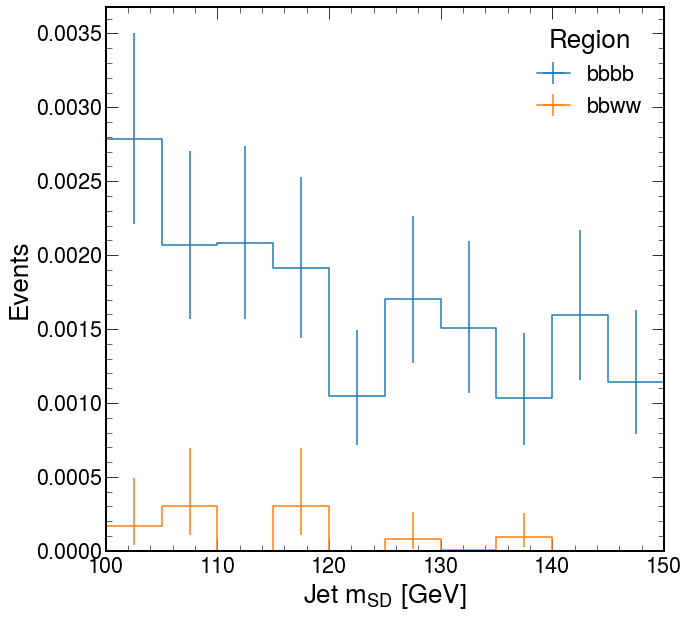

In [11]:
fig = hist.plot1d(output['templates'].project('region','mass'),overlay='region')

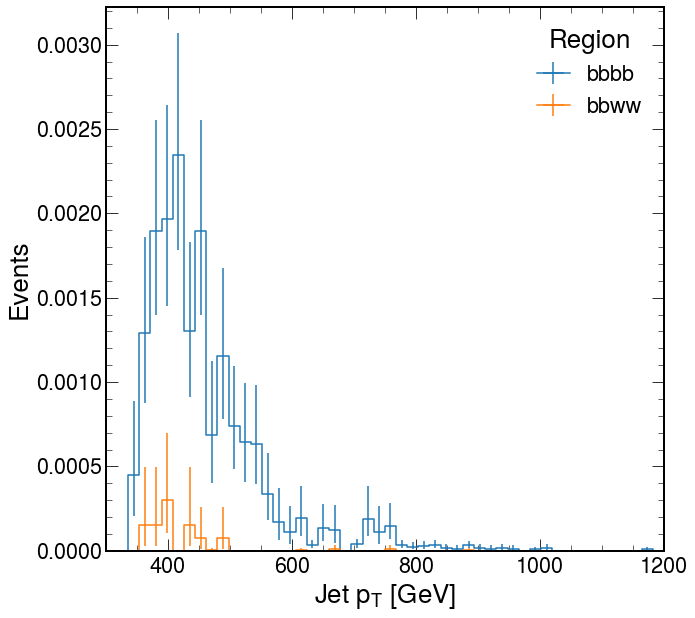

In [12]:
fig = hist.plot1d(output['templates'].project('region','pt'),overlay='region')

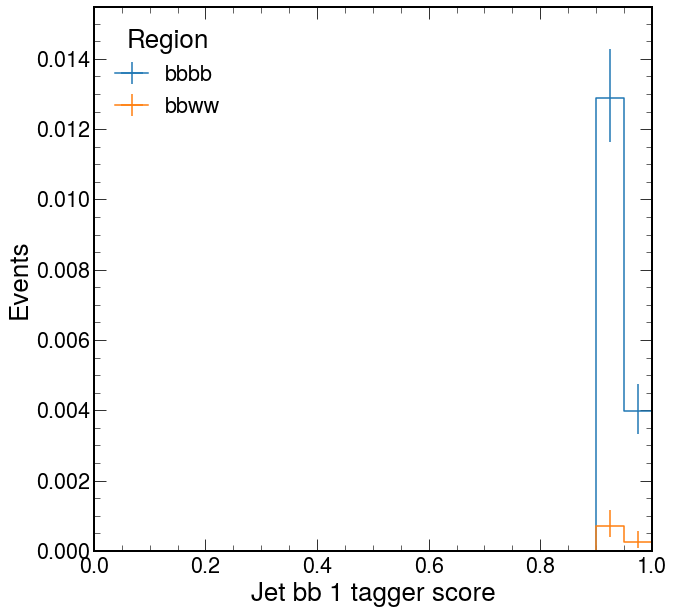

In [13]:
fig = hist.plot1d(output['templates'].project('region','bbtag1'),overlay='region')

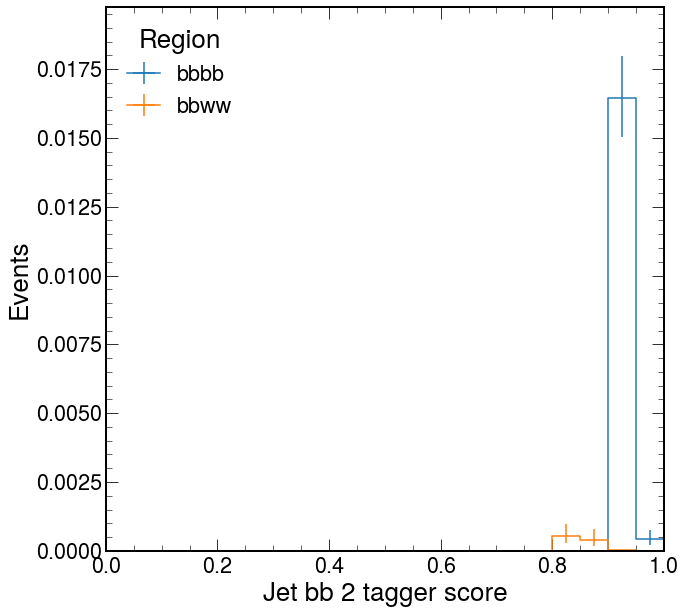

In [14]:
fig = hist.plot1d(output['templates'].project('region','bbtag2'),overlay='region')

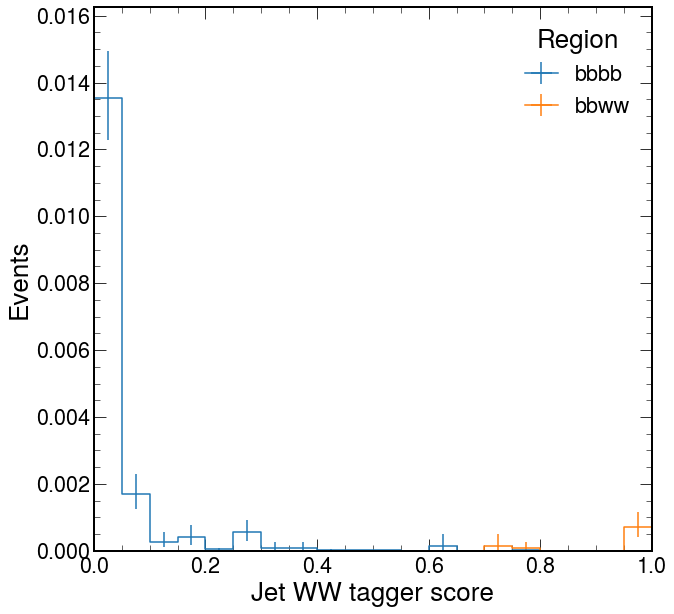

In [15]:
fig = hist.plot1d(output['templates'].project('region','wwtag'),overlay='region')